# Spatiotemporal Regression

In [ ]:
%%capture
!pip3 install pygeohash tensorflow==2.0.0-alpha0 tpot

In [19]:
import math
import datetime

import numpy as np
import pandas as pd
import pygeohash as gh
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import scipy.fftpack

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import BayesianRidge, ARDRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from xgboost import plot_tree
import xgboost

from tpot import TPOTRegressor

import tensorflow.keras as tfk

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import _pickle as cPickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

## The data

### Load the preprocessed data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd '/content/gdrive/My Drive/Colab Notebooks/aiforsea'

/content/gdrive/My Drive/Colab Notebooks/aiforsea


In [2]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Circular embedding

In [3]:
%%time
df['weekday_sin'] = np.sin(2*np.pi*df['weekday'].values/7)
df['weekday_cos'] = np.cos(2*np.pi*df['weekday'].values/7)

df['hour_sin']    = np.sin(2*np.pi*df['hour'].values/24)
df['hour_cos']    = np.cos(2*np.pi*df['hour'].values/24)

df['minutes_sin'] = np.sin(2*np.pi*df['minutes'].values/60)
df['minutes_cos'] = np.cos(2*np.pi*df['minutes'].values/60)

Wall time: 2.1 s


In [4]:
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,weekday_sin,weekday_cos,hour_sin,hour_cos,minutes_sin,minutes_cos
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687,0.781831,0.62349,0.0,1.0,0.0,1.0
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673,0.781831,0.62349,0.0,1.0,0.0,1.0
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659,0.781831,0.62349,0.0,1.0,0.0,1.0
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646,0.781831,0.62349,0.0,1.0,0.0,1.0
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632,0.781831,0.62349,0.0,1.0,0.0,1.0


### Collect information for each location

In [5]:
locations = df['geohash6'].unique()
print(len(locations), locations)

1329 ['qp02yc' 'qp02z1' 'qp02z3' ... 'qp0djw' 'qp0djy' 'qp0dnn']


In [6]:
df_locinfo = pd.DataFrame()

In [7]:
df_locinfo['median'] = df.groupby(['geohash6'])['demand'].median()
df_locinfo['mean'] = df.groupby(['geohash6'])['demand'].mean()
df_locinfo['count'] = df.groupby(['geohash6'])['demand'].count()

df_locinfo = df_locinfo.sort_values(by=['mean', 'median'])
df_locinfo.tail()

,median,mean,count
geohash6,,,
qp03yb,0.777774,0.694499,5856
qp03xw,0.972542,0.745806,5856
qp03xx,1.000000,0.751653,5856
qp09e5,1.000000,0.759626,5856
qp09d9,1.000000,0.867371,5856


### Detrend the data

In [8]:
# median_demand = df['demand'].median()
# mean_demand = df['demand'].mean()
# 
# print("Median demand:", median_demand)
# print("Mean demand:", mean_demand)

#### Detrend by mean demand

In [9]:
# df['demand_detrended'] = df.apply(lambda x : x.demand - df_locmedian[x.geohash6], axis=1)
# df.head()

### Train-test split

In [10]:
# df = df[df['in_raw']]
len(df)

7782624

In [11]:
X_data = df[['latitude', 'longitude',
             'day', 'hour', 'minutes',
             'weekday_sin', 'weekday_cos',
             'hour_sin', 'hour_cos',
             'minutes_sin', 'minutes_cos']]
# y_data = df['demand_detrended']
y_data = df['demand']

In [12]:
X_data.tail()

,latitude,longitude,day,hour,minutes,weekday_sin,weekday_cos,hour_sin,hour_cos,minutes_sin,minutes_cos
7782619,-5.237732,90.928345,61,23,45,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16
7782620,-5.237732,90.939331,61,23,45,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16
7782621,-5.237732,90.950317,61,23,45,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16
7782622,-5.237732,90.961304,61,23,45,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16
7782623,-5.237732,90.972290,61,23,45,-0.974928,-0.222521,-0.258819,0.965926,-1.0,-1.836970e-16


In [13]:
y_data.tail()

7782619    0.0
7782620    0.0
7782621    0.0
7782622    0.0
7782623    0.0
Name: demand, dtype: float64

In [28]:
test_index = (X_data['day'] == 61) & ((X_data['hour'] == 23) | ((X_data['hour'] == 22) & (X_data['minutes'] == 45)))
train_index = (~test_index) & (X_data['day'] >= 61-14)

In [29]:
X_train, X_test = X_data[train_index], X_data[test_index]
y_train, y_test = y_data[train_index], y_data[test_index]

In [30]:
X_train = X_train.drop(['hour', 'minutes'], axis=1)
X_test  = X_test.drop(['hour', 'minutes'], axis=1)

## Polynomial Regression

In [17]:
class ColumnExtractor(object):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

### Train polynomial regressors

Loss with full data:
- degree 1 polynomial regression loss: 0.048594363494371254
- degree 2 polynomial regression loss: 0.04912314854368942
- degree 3 polynomial regression loss: 0.0495815584173599

Loss with partial data:
- degree 1 polynomial regression loss: 0.0665519070143781
- degree 2 polynomial regression loss: 0.06692959565100215
- degree 3 polynomial regression loss: 0.06690783480405857

In [18]:
poly_regressors = [None]
for deg in range(1, 3+1):
  poly_reg = Pipeline([
    ('features', FeatureUnion([
        ('spatial', Pipeline([
            ('extract', ColumnExtractor(columns=['latitude', 'longitude'])),
            ('poly', PolynomialFeatures(degree=deg))
        ])),
        ('temporal', ColumnExtractor(columns=['day',
                                             'weekday_sin', 'weekday_cos',
                                             'hour_sin', 'hour_cos',
                                             'minutes_sin', 'minutes_cos']))
    ])),
    ('std_scaler', StandardScaler()),
    ('lr', Ridge())
  ])
  poly_reg = poly_reg.fit(X_train, y_train)
  poly_regressors.append(poly_reg)
  
  y_pred = poly_reg.predict(X_test)
  print("degree", deg, "polynomial regression loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

degree 1 polynomial regression loss: 0.048594363494371254
degree 2 polynomial regression loss: 0.04912314854368942
degree 3 polynomial regression loss: 0.0495815584173599


### Save the model

In [32]:
with open('models/geotemporal/poly_regressors.pkl', 'wb') as fid:
    cPickle.dump(poly_regressors, fid)

### Features of 1st degree polynomial

In [23]:
poly_features = poly_regressors[1]['features'].transformer_list[0][1]['poly'].get_feature_names(['lat', 'long'])
poly_features += ['day', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'minutes_sin', 'minutes_cos']
poly_features

['1',
 'lat',
 'long',
 'day',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos',
 'minutes_sin',
 'minutes_cos']

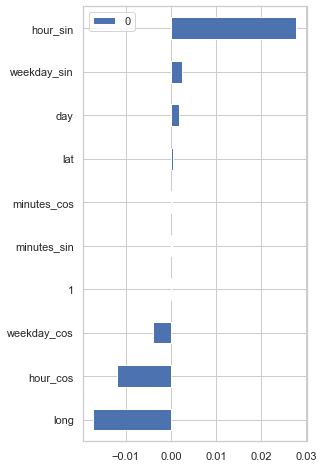

In [24]:
df_coefs = pd.DataFrame(np.expand_dims(poly_regressors[1]['lr'].coef_, axis=0),
                        columns=poly_features).T
df_coefs.sort_values(by=0).plot.barh(figsize=(4, 8))

### Features of 3rd degree polynomial

In [25]:
poly_features = poly_regressors[3]['features'].transformer_list[0][1]['poly'].get_feature_names(['lat', 'long'])
poly_features += ['day', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos', 'minutes_sin', 'minutes_cos']
poly_features

['1',
 'lat',
 'long',
 'lat^2',
 'lat long',
 'long^2',
 'lat^3',
 'lat^2 long',
 'lat long^2',
 'long^3',
 'day',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos',
 'minutes_sin',
 'minutes_cos']

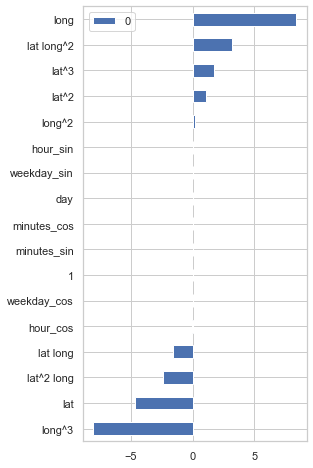

In [26]:
df_coefs = pd.DataFrame(np.expand_dims(poly_regressors[3]['lr'].coef_, axis=0),
                        columns=poly_features).T
df_coefs.sort_values(by=0).plot.barh(figsize=(4, 8))

## Random Forest

Loss with full data: 0.09902381906309178

Loss with partial data: 0.09902381906309177

Loss with parital data and dropped 'day' column: 0.09902381906309199

In [31]:
X_train = X_train.drop('day', axis=1)
X_test  = X_test.drop('day', axis=1)

### Train random forest model

In [34]:
rfc = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1,
                            random_state=0, warm_start=True, verbose=1)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=1,
                      warm_start=True)

In [35]:
y_pred = rfc.predict(X_test)
print("Random Forest loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Random Forest loss: 0.07614693023190335


### Save the model

In [36]:
with open('models/geotemporal/random_forest.pkl', 'wb') as fid:
    cPickle.dump(rfc, fid)

### Inspect the first tree

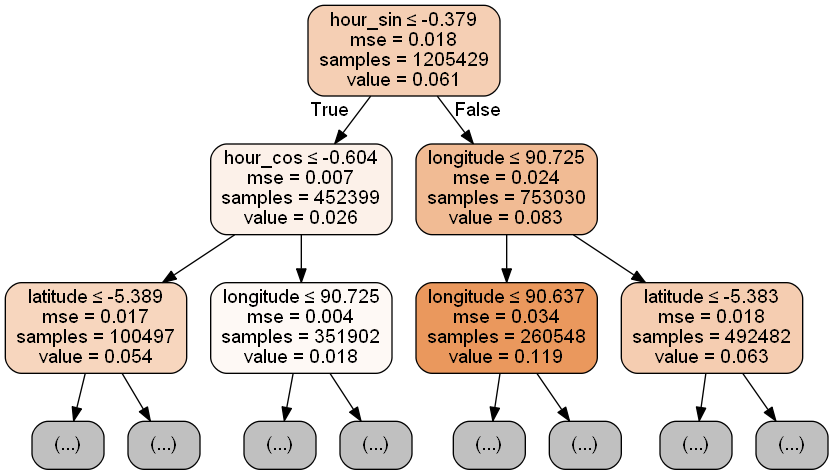

In [37]:
dot_data = StringIO()
export_graphviz(rfc.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_train.columns,
                max_depth=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## XGBoost

Loss with partial data: 0.07101681478370973

Loss with full data: 0.07101681478370973

Loss with partial data and dropped 'day' column: 0.06948751120370361

In [38]:
xgb = XGBRegressor(random_state=0, n_jobs=-1, eval_metric='rmse')
xgb.fit(X_train, y_train)

C:\Users\admin\.conda\envs\py36\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:09:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [39]:
y_pred = xgb.predict(X_test)
print("XGBoost loss:", math.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost loss: 0.04855022108270493


### Save the model

In [41]:
with open('models/geotemporal/xgboost.pkl', 'wb') as fid:
    cPickle.dump(xgb, fid)

## Plain Neural Network

In [ ]:
X_train_means = X_train.mean()
X_train_maxs  = X_train.max()
X_train_mins  = X_train.min()

In [ ]:
X_train_normed = (X_train - X_train_means) / (X_train_maxs - X_train_mins)
X_test_normed = (X_test - X_train_means) / (X_train_maxs - X_train_mins)

In [ ]:
def build_model():
    model = tfk.Sequential([
        tfk.layers.Input((9,)),
        tfk.layers.Dense(32, activation='relu'),
        tfk.layers.Dense(16, activation='relu'),
        tfk.layers.Dense(8, activation='relu'),
        tfk.layers.Dense(1)
    ], name='nn_spatiotemporal')

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
model = build_model()

In [30]:
model.summary()

Model: "nn_spatiotemporal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [36]:
class PrintDot(tfk.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0:
      print('')
    print('.', end='')

early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
  X_train_normed, y_train,
  epochs=100, validation_split=0.2, verbose=1,
  callbacks=[early_stop])  # PrintDot()

Train on 1525692 samples, validate on 381423 samples
Epoch 1/1000
1525692/1525692 [==============================] - 62s 41us/sample - loss: 0.0054 - mean_absolute_error: 0.0424 - val_loss: 0.0064 - val_mean_absolute_error: 0.0464
Epoch 2/1000
1525692/1525692 [==============================] - 64s 42us/sample - loss: 0.0053 - mean_absolute_error: 0.0422 - val_loss: 0.0060 - val_mean_absolute_error: 0.0441
Epoch 3/1000
1525692/1525692 [==============================] - 62s 40us/sample - loss: 0.0053 - mean_absolute_error: 0.0422 - val_loss: 0.0058 - val_mean_absolute_error: 0.0447
Epoch 4/1000
1525692/1525692 [==============================] - 61s 40us/sample - loss: 0.0053 - mean_absolute_error: 0.0422 - val_loss: 0.0061 - val_mean_absolute_error: 0.0448
Epoch 5/1000
1525692/1525692 [==============================] - 61s 40us/sample - loss: 0.0052 - mean_absolute_error: 0.0420 - val_loss: 0.0059 - val_mean_absolute_error: 0.0437
Epoch 6/1000
1525692/1525692 [===========================

KeyboardInterrupt: ignored

In [41]:
loss, mae = model.evaluate(X_test_normed, y_test, verbose=0)

print("Testing set Root Mean Squared Error: {:f}".format(math.sqrt(loss)))

Testing set Root Mean Squared Error: 0.049747
